In [51]:
import json, os

### Upload datasets from private API (remove)

In [2]:
# AIXÒ FER-HO PRIVAT , de moment esta aixi per estalviar uploadear els datasets cada cop

data = {
    "username":"albertroca29",
    "key":"abb86cea6e8b29e5a3002793d9210162"
}
with open("kaggle.json", "w") as f:
    json.dump(data, f)

os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d albertroca29/arlsgqrms/UH_2023_TRAIN.txt

 83% 34.0M/40.8M [00:00<00:00, 54.2MB/s]
100% 40.8M/40.8M [00:00<00:00, 65.9MB/s]


### Unzip the zip file to have the datasets 

In [3]:
!unzip \*.zip  && rm *.zip

Archive:  arlsgqrms.zip
  inflating: DATOS_ETO.TXT           
  inflating: DATOS_METEO.TXT         
  inflating: UH_2023_TRAIN.txt       


Pandas dataset

In [91]:
import pandas as pd


def load_dataset(path): 
    dataset = pd.read_csv(path, header=0, delimiter='|')
    return dataset

train = load_dataset('UH_2023_TRAIN.txt')
meteo = load_dataset('DATOS_METEO.TXT')
eto = load_dataset('DATOS_ETO.TXT')

df = {'train':train,'meteo':meteo,'eto':eto}

In [52]:
import matplotlib.pyplot as plt
import numpy as np

Dimensions

In [92]:
_=[print(nom,'\t',dataset.shape) for nom,dataset in df.items()]

train 	 (9601, 11)
meteo 	 (1223660, 33)
eto 	 (51180, 275)


In [93]:
_=[print(nom,'\t',list(dataset.columns)) for nom,dataset in df.items()]

train 	 ['CAMPAÑA', 'ID_FINCA', 'ID_ZONA', 'ID_ESTACION', 'ALTITUD', 'VARIEDAD', 'MODO', 'TIPO', 'COLOR', 'SUPERFICIE', 'PRODUCCION']
meteo 	 ['validTimeUtc', 'precip1Hour', 'precip6Hour', 'precip24Hour', 'precip2Day', 'precip3Day', 'precip7Day', 'precipMtd', 'precipYtd', 'pressureChange', 'pressureMeanSeaLevel', 'relativeHumidity', 'snow1Hour', 'snow6Hour', 'snow24Hour', 'snow2Day', 'snow3Day', 'snow7Day', 'snowMtd', 'snowSeason', 'snowYtd', 'temperature', 'temperatureChange24Hour', 'temperatureMax24Hour', 'temperatureMin24Hour', 'temperatureDewPoint', 'temperatureFeelsLike', 'uvIndex', 'visibility', 'windDirection', 'windGust', 'windSpeed', 'ID_ESTACION']
eto 	 ['date', 'DewpointLocalAfternoonAvg', 'DewpointLocalAfternoonMax', 'DewpointLocalAfternoonMin', 'DewpointLocalDayAvg', 'DewpointLocalDayMax', 'DewpointLocalDayMin', 'DewpointLocalDaytimeAvg', 'DewpointLocalDaytimeMax', 'DewpointLocalDaytimeMin', 'DewpointLocalEveningAvg', 'DewpointLocalEveningMax', 'DewpointLocalEveningMin', '

NaNs en train

In [94]:
train.isnull().sum()/train.shape[0]

CAMPAÑA        0.000000
ID_FINCA       0.000000
ID_ZONA        0.000000
ID_ESTACION    0.000000
ALTITUD        0.005624
VARIEDAD       0.000000
MODO           0.000000
TIPO           0.000000
COLOR          0.000000
SUPERFICIE     0.000000
PRODUCCION     0.111968
dtype: float64

**Altitud**

Omplir-los amb la mitjana ?

De moment les borro

In [95]:
train = train.dropna(subset=['ALTITUD'])
train.shape

(9547, 11)

**Produccion**

Seperarem els Nans per posar les prediccions finals

In [96]:
train22 = train.copy()
train = train.dropna(subset=['PRODUCCION'])

### A Eto

In [97]:
pd.set_option('display.max_rows', None)

print(eto.isnull().sum()/eto.shape[0])

date                                           0.000000
DewpointLocalAfternoonAvg                      0.000000
DewpointLocalAfternoonMax                      0.000000
DewpointLocalAfternoonMin                      0.000000
DewpointLocalDayAvg                            0.000000
DewpointLocalDayMax                            0.000000
DewpointLocalDayMin                            0.000000
DewpointLocalDaytimeAvg                        0.000000
DewpointLocalDaytimeMax                        0.000000
DewpointLocalDaytimeMin                        0.000000
DewpointLocalEveningAvg                        0.000000
DewpointLocalEveningMax                        0.000000
DewpointLocalEveningMin                        0.000000
DewpointLocalMorningAvg                        0.000391
DewpointLocalMorningMax                        0.000391
DewpointLocalMorningMin                        0.000391
DewpointLocalNighttimeAvg                      0.000000
DewpointLocalNighttimeMax                      0

Remove attributes with more than 60% of NaNs

In [98]:
eto = eto.dropna(thresh=len(eto)*0.5, axis=1)
eto.shape

(51180, 212)

MSLP

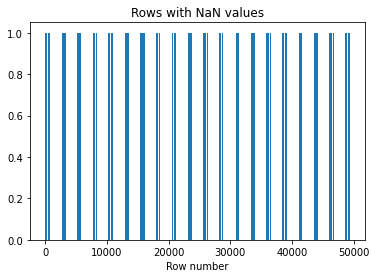

In [83]:
nan_rows = eto[eto['MSLPLocalDayAvg'].isna()].index.tolist()

# plot a bar chart of the row numbers
plt.bar(nan_rows, [1] * len(nan_rows))
plt.xlabel('Row number')
plt.title('Rows with NaN values')
plt.show()

MANERES DE RESOLDRA-HO

Detectar on falta aquesta informació

1. Omplirho d'alguna manera
- Mitjana de ....

2. Elminar-les (seria eliminar tota la informació de la pressió i no mola)

**De moment les elimino però sha de canviar**

In [99]:
eto = eto.dropna(thresh=len(eto)*0.71, axis=1)
eto.shape

(51180, 191)

eliminar files amb nans

In [100]:
# numero de files amb nans

eto.isna().any(axis=1).sum()

20

In [101]:
eto = eto.dropna(how='any')
eto.shape

(51160, 191)

### Relacio entre dades no meteo

In [102]:
train.dtypes

CAMPAÑA          int64
ID_FINCA         int64
ID_ZONA          int64
ID_ESTACION      int64
ALTITUD         object
VARIEDAD         int64
MODO             int64
TIPO             int64
COLOR            int64
SUPERFICIE     float64
PRODUCCION     float64
dtype: object

Altitud te rows de l'estil 660-670, que podriem convertir amb la mitjana dels dos

In [103]:
for i in range(train.shape[0]):
    valor = train['ALTITUD'].values[i]
    if(len(valor)>3):
        train['ALTITUD'].values[i] = int((int(valor[:3])+int(valor[-3:]))/2)
    else:
        train['ALTITUD'].values[i] = int(valor)

train['ALTITUD'] = pd.to_numeric(train['ALTITUD'])

<AxesSubplot:>

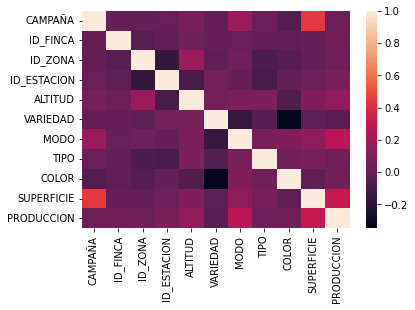

In [104]:
import seaborn as sns

sns.heatmap(train.corr())

Primera prediccio , anem a predir només per l'any 2021 de moment

In [115]:
# PRIMERA PREDICCIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV,ElasticNet,ElasticNetCV
import time
from sklearn.metrics import mean_squared_error as MSE
import math
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as RFR

X_columns = train.drop('PRODUCCION',axis=1).columns
X = train.drop('PRODUCCION',axis=1).values
y = train.PRODUCCION.values

# norm
mm = make_pipeline(StandardScaler(), MinMaxScaler())
X_norm = mm.fit_transform(X)

X_train, X_test = X_norm[X[:,0]!=21,:] , X_norm[X[:,0]==21,:] 
y_train, y_test = y[X[:,0]!=21] , y[X[:,0]==21] 



# Defining the hyper parameters

# hps = {
#     'max_depth': 3,
#     'min_samples_split': 4,
#     'random_state': 0
# }

models = {
    'Ridge':Ridge(),
    'SVR':SVR(),
    'DTR':DTR(),
    'RFR':RFR(),
    'ElasticNet':ElasticNet()
}

for nom,m in models.items():
    t = time.time()
    m.fit(X_train, y_train)

    y_pred = m.predict(X_test)

    mse = MSE(y_test, y_pred)
    print(nom,'RMSE= ',math.sqrt(mse))
    print("temps = %3.4fs"%(time.time()-t))


RidgeCV RMSE=  9871.027565571581
temps = 0.0145s
SVR RMSE=  14559.384944931186
temps = 3.0695s
DTR RMSE=  7672.727833994271
temps = 0.0285s
RFR RMSE=  6354.80936422937
temps = 2.2716s
ElasticNetCV RMSE=  13363.406717422762
temps = 0.0173s


PLOT COEFFICIENTS (per model lineal)

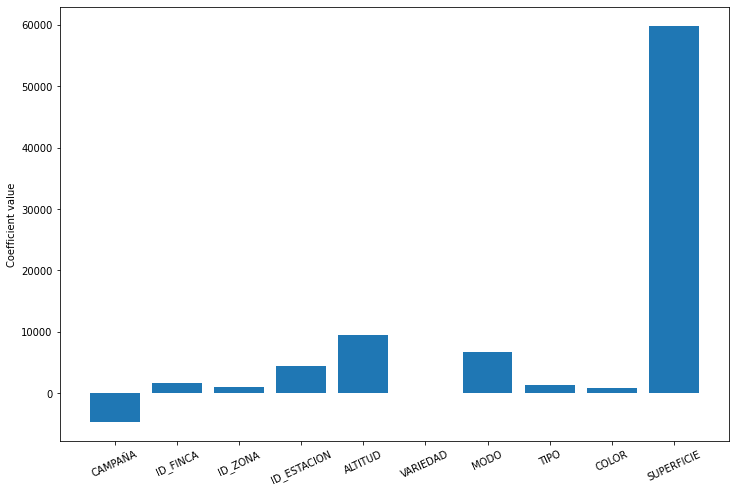

In [116]:
import matplotlib.pyplot as plt
feature_importance_ridge = { X_columns[i] : models['RidgeCV'].coef_[i] for i in range(X_norm.shape[1]) }
plt.figure(figsize=(12,8))
plt.bar(feature_importance_ridge.keys(),feature_importance_ridge.values())
plt.xticks(rotation=25)
plt.ylabel('Coefficient value')
plt.show()


Feature importance RandomForest

Feature importance: {'CAMPAÑA': 0.09493, 'ID_FINCA': 0.28925, 'ID_ZONA': 0.0988, 'ID_ESTACION': 0.05499, 'ALTITUD': 0.11841, 'VARIEDAD': 0.19028, 'MODO': 0.07598, 'TIPO': 0.00157, 'COLOR': 0.0078, 'SUPERFICIE': 0.06799}


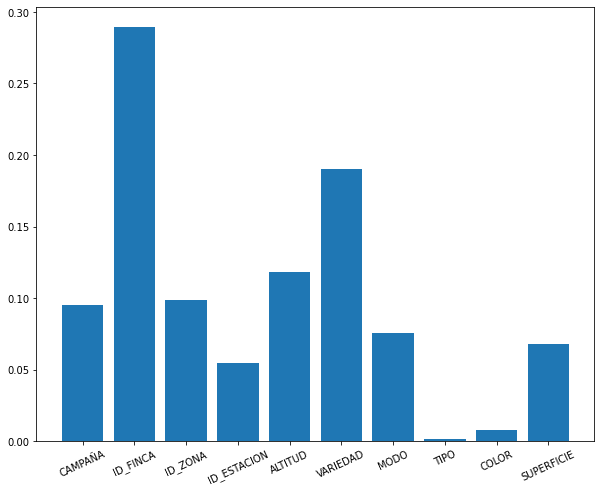

In [117]:
# Extracting the importances by sklearn 
importances_dtr = models['RFR'].feature_importances_

# Creating a dataframe with the feature importance by sklearn
feature_importance_dtr = {}
for i, feature in enumerate(X_columns):
    feature_importance_dtr[feature] = round(importances_dtr[i], 5)

plt.figure(figsize=(10,8))
print(f"Feature importance: {feature_importance_dtr}")
plt.bar(feature_importance_dtr.keys(), feature_importance_dtr.values())
plt.xticks(rotation=25)
plt.show()

A partir d'aqui nomes treballarem amb les bases de dades eto i train, deixan la de meteo de banda.

### REPERTICIO PER ANY (no te sentit, es nomes per familiaritzar-se amb l'entorn)

INTENTEM POSAR NOVEMBRE I DESEMBRE DEL ANY ANTERIOR

Afegint tots els atributs de eto, passats de dia a **any**

In [ ]:
eto['CAMPAÑA'] =eto['date']/10000-2000 + ((eto['date'].astype(str).str[4:6].astype(float) - 0.5)/10).astype(int)
eto['CAMPAÑA'] = eto['CAMPAÑA'].astype(int)

In [ ]:
# print(int((int(str(eto['date'])[4:6])-1)/10))
print( ((eto['date'].astype(str).str[4:6].astype(float) - 0.5)/10).astype(int) )

0        0
1        0
2        0
3        0
4        0
        ..
51175    0
51176    0
51177    0
51178    0
51179    0
Name: date, Length: 51180, dtype: int64


In [ ]:
print(eto.shape)

(51180, 276)


In [ ]:
means = eto.groupby(['CAMPAÑA','ID_ESTACION']).mean()

In [ ]:
eto.describe()

,date,DewpointLocalAfternoonAvg,DewpointLocalAfternoonMax,DewpointLocalAfternoonMin,DewpointLocalDayAvg,DewpointLocalDayMax,DewpointLocalDayMin,DewpointLocalDaytimeAvg,DewpointLocalDaytimeMax,DewpointLocalDaytimeMin,...,WindSpeedLocalMorningMax,WindSpeedLocalMorningMin,WindSpeedLocalNighttimeAvg,WindSpeedLocalNighttimeMax,WindSpeedLocalNighttimeMin,WindSpeedLocalOvernightAvg,WindSpeedLocalOvernightMax,WindSpeedLocalOvernightMin,ID_ESTACION,CAMPAÑA
count,5.118000e+04,51180.000000,51180.000000,51180.000000,51180.000000,51180.000000,51180.000000,51180.000000,51180.000000,51180.000000,...,51160.000000,51160.000000,51180.000000,51180.000000,51180.000000,51180.000000,51180.000000,51180.000000,51180.000000,51180.000000
mean,2.018560e+07,280.817790,281.829791,279.949850,281.334281,283.782683,278.840741,281.007812,282.710051,279.182282,...,3.659683,1.916568,2.510084,3.916938,1.587659,2.213939,2.672382,1.765930,9.500000,18.492771
std,2.056121e+04,5.740212,5.644393,5.862113,5.779998,5.698248,6.048484,5.712349,5.597571,5.976297,...,2.112686,1.585190,1.467940,1.748038,1.287805,1.611146,1.790667,1.456031,5.766338,2.063076
min,2.015063e+07,259.000000,261.000000,256.000000,261.000000,264.000000,256.000000,259.000000,262.000000,256.000000,...,0.400000,0.000000,0.200000,0.400000,0.000000,0.000000,0.100000,0.000000,0.000000,15.000000
25%,2.017033e+07,277.000000,278.000000,276.000000,277.000000,280.000000,274.700000,277.000000,279.000000,275.000000,...,2.100000,0.900000,1.600000,2.700000,0.800000,1.200000,1.500000,0.800000,4.750000,17.000000
50%,2.018123e+07,281.000000,282.000000,280.000000,281.200000,283.700000,279.000000,281.000000,282.800000,279.200000,...,3.100000,1.400000,2.100000,3.700000,1.200000,1.700000,2.100000,1.300000,9.500000,18.000000
75%,2.020093e+07,285.000000,286.000000,284.000000,286.000000,288.300000,283.300000,285.200000,287.000000,283.700000,...,4.600000,2.500000,2.900000,4.700000,2.000000,2.700000,3.200000,2.200000,14.250000,20.000000
max,2.022063e+07,294.800000,295.400000,294.300000,295.000000,296.400000,294.000000,295.000000,295.800000,294.200000,...,15.400000,12.900000,15.100000,16.300000,12.700000,15.300000,16.300000,13.800000,19.000000,22.000000


In [ ]:
eto.head()

,date,DewpointLocalAfternoonAvg,DewpointLocalAfternoonMax,DewpointLocalAfternoonMin,DewpointLocalDayAvg,DewpointLocalDayMax,DewpointLocalDayMin,DewpointLocalDaytimeAvg,DewpointLocalDaytimeMax,DewpointLocalDaytimeMin,...,WindSpeedLocalMorningMax,WindSpeedLocalMorningMin,WindSpeedLocalNighttimeAvg,WindSpeedLocalNighttimeMax,WindSpeedLocalNighttimeMin,WindSpeedLocalOvernightAvg,WindSpeedLocalOvernightMax,WindSpeedLocalOvernightMin,ID_ESTACION,CAMPAÑA
0,20150629,285.9,285.9,285.9,286.0,287.0,285.4,285.9,285.9,285.9,...,NaN,NaN,2.6,5.0,1.1,1.7,2.1,1.1,13,15
1,20150630,283.0,283.6,282.5,284.3,286.5,282.5,283.2,283.9,282.5,...,3.8,1.4,2.7,5.2,1.4,1.5,1.9,1.4,13,15
2,20150701,286.1,286.5,285.5,285.8,288.0,283.8,285.4,286.5,283.8,...,4.3,1.2,3.0,5.7,1.4,1.9,2.8,1.4,13,15
3,20150702,288.9,289.4,287.9,288.3,291.8,286.1,287.7,289.4,286.1,...,2.3,1.2,3.6,5.4,2.4,2.7,3.4,2.4,13,15
4,20150703,289.1,290.4,288.5,290.5,293.0,287.8,290.6,293.0,288.5,...,5.0,2.3,3.1,6.0,1.5,1.9,2.2,1.5,13,15


In [ ]:
means.head()

date  DewpointLocalAfternoonAvg  \
CAMPAÑA ID_ESTACION                                            
15      0            2.015086e+07                   288.3280   
        1            2.015086e+07                   286.6800   
        2            2.015086e+07                   288.3832   
        3            2.015086e+07                   287.7360   
        4            2.015086e+07                   287.2704   

                     DewpointLocalAfternoonMax  DewpointLocalAfternoonMin  \
CAMPAÑA ID_ESTACION                                                         
15      0                             289.0560                   287.6400   
        1                             287.4960                   285.9440   
        2                             289.0936                   287.7464   
        3                             288.6240                   287.0800   
        4                             288.0168                   286.6144   

                     DewpointLocalDayAvg  DewpointLocalDayMax  \
CAMPAÑA ID_ESTACION                                             
15      0                       288.8720             290.9280   
        1                       287.4400             289.7440   
        2                       288.7464             290.8856   
        3                       288.4800             290.7600   
        4                       287.9672             290.1744   

                     DewpointLocalDayMin  DewpointLocalDaytimeAvg  \
CAMPAÑA ID_ESTACION                                                 
15      0                       286.7440                 288.4560   
        1                       285.1040                 287.0640   
        2                       286.5072                 288.4416   
        3                       286.2240                 288.0960   
        4                       285.7400                 287.5704   

                     DewpointLocalDaytimeMax  DewpointLocalDaytimeMin  ...  \
CAMPAÑA ID_ESTACION                                                    ...   
15      0                           289.8320                 287.0320  ...   
        1                           288.6400                 285.3920  ...   
        2                           289.9392                 286.7176  ...   
        3                           289.5920                 286.4880  ...   
        4                           289.0576                 285.9952  ...   

                     WindSpeedLocalEveningMin  WindSpeedLocalMorningAvg  \
CAMPAÑA ID_ESTACION                                                       
15      0                              1.8312                  1.958871   
        1                              2.0240                  2.020968   
        2                              1.8888                  1.886290   
        3                              1.9928                  2.008871   
        4                              2.0776                  1.969355   

                     WindSpeedLocalMorningMax  WindSpeedLocalMorningMin  \
CAMPAÑA ID_ESTACION                                                       
15      0                            2.736290                  1.354032   
        1                            2.778226                  1.370161   
        2                            2.619355                  1.321774   
        3                            2.767742                  1.400000   
        4                            2.708871                  1.365323   

                     WindSpeedLocalNighttimeAvg  WindSpeedLocalNighttimeMax  \
CAMPAÑA ID_ESTACION                                                           
15      0                                2.2024                      3.7688   
        1                                2.4064                      3.9960   
        2                                2.2280                      3.7392   
        3                                2.3672                      3.9456   
        4                  

In [ ]:
t3 = t2.copy()
t3 = t3.merge(means,on=['CAMPAÑA','ID_ESTACION'])

<AxesSubplot:>

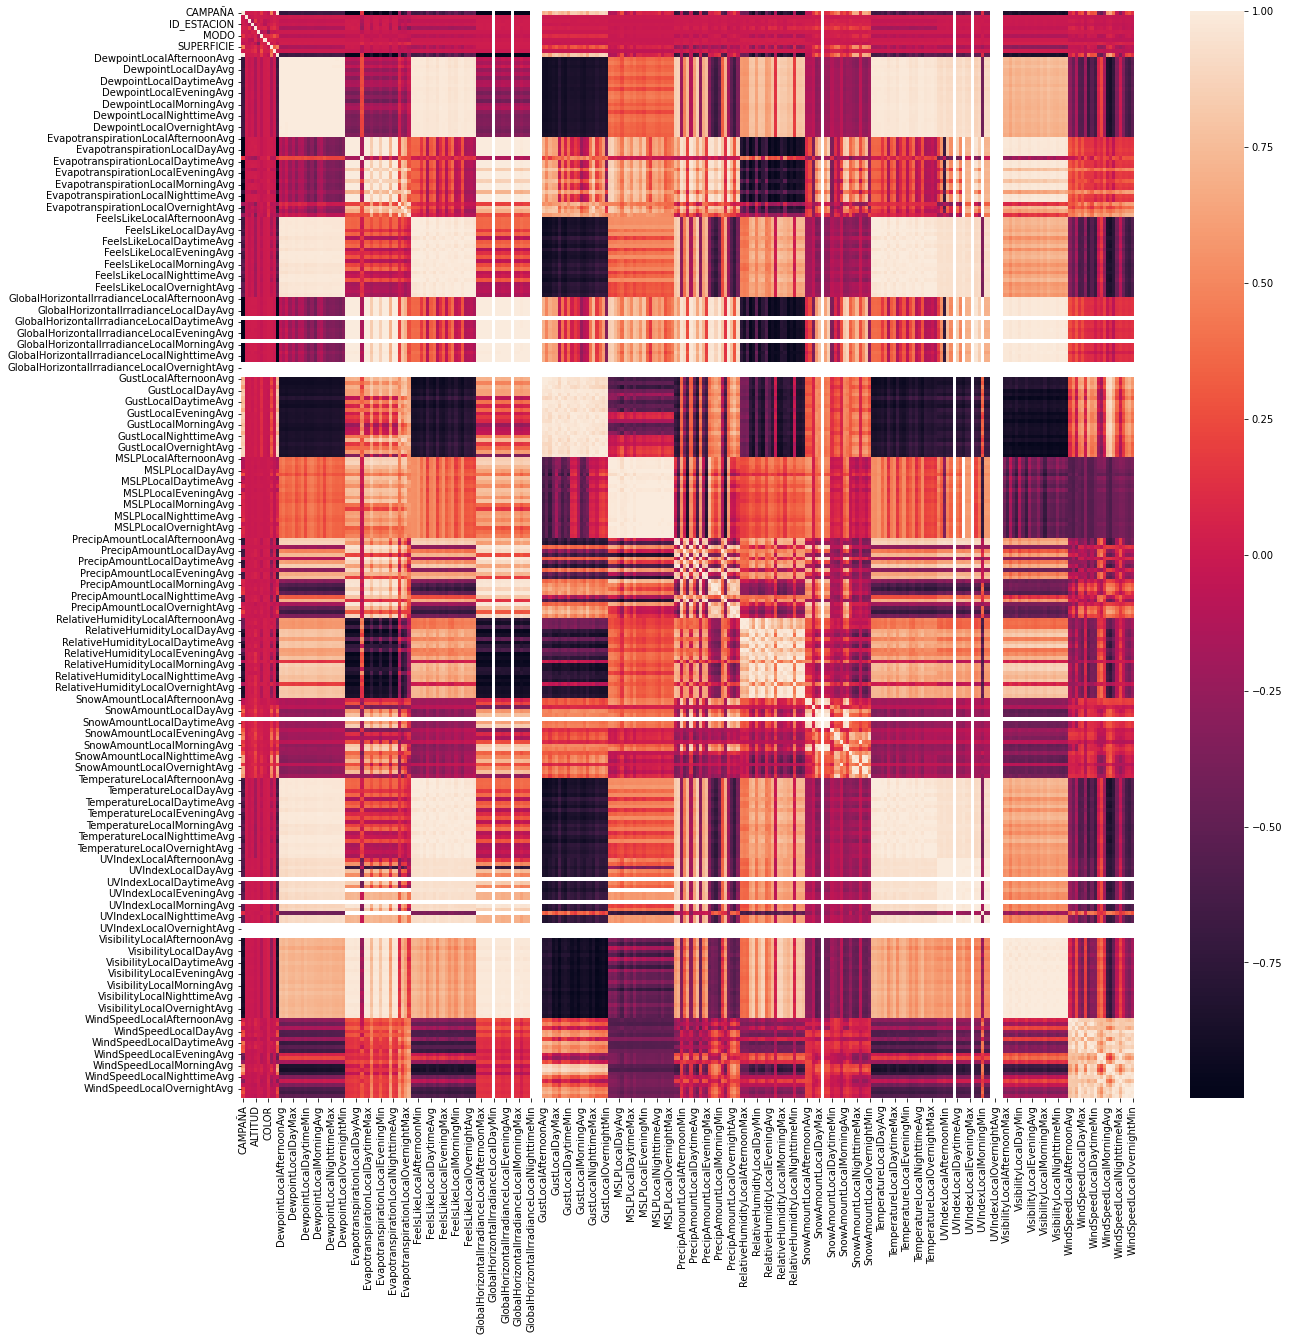

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
sns.heatmap(t3.corr())

In [ ]:
t3.describe()

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,...,WindSpeedLocalEveningMin,WindSpeedLocalMorningAvg,WindSpeedLocalMorningMax,WindSpeedLocalMorningMin,WindSpeedLocalNighttimeAvg,WindSpeedLocalNighttimeMax,WindSpeedLocalNighttimeMin,WindSpeedLocalOvernightAvg,WindSpeedLocalOvernightMax,WindSpeedLocalOvernightMin
count,7338.000000,7338.000000,7338.00000,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000,...,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000
mean,17.955983,50751.208504,499.11202,12.191605,578.994004,45.515263,1.509131,0.013900,0.844917,0.597847,...,2.005908,2.620874,3.513160,1.849873,2.478177,3.866582,1.579737,2.163474,2.604781,1.733061
std,2.010494,29022.764870,260.99404,4.775919,76.102061,23.712210,0.499951,0.117085,0.362009,1.678556,...,0.153261,0.337851,0.396959,0.269083,0.196158,0.227709,0.169607,0.239963,0.270097,0.213820
min,15.000000,200.000000,7.00000,1.000000,370.000000,4.000000,1.000000,0.000000,0.000000,0.000000,...,1.369589,1.886290,2.619355,1.321774,1.964658,3.251507,1.034795,1.613699,2.073151,1.149315
25%,16.000000,25026.000000,284.00000,7.000000,490.000000,17.000000,1.000000,0.000000,1.000000,0.000000,...,1.916800,2.502459,3.311475,1.704372,2.316000,3.704658,1.423200,1.968852,2.409563,1.538525
50%,18.000000,50799.000000,464.00000,12.000000,610.000000,52.000000,2.000000,0.000000,1.000000,0.000000,...,2.015068,2.610929,3.607123,1.872131,2.496712,3.874400,1.594795,2.223014,2.648634,1.767397
75%,20.000000,76350.500000,726.00000,16.000000,635.000000,59.000000,2.000000,0.000000,1.000000,0.289860,...,2.094536,2.864932,3.776986,2.038630,2.585753,3.957808,1.702192,2.285479,2.740548,1.850820
max,21.000000,99693.000000,990.00000,19.000000,820.000000,94.000000,2.000000,1.000000,1.000000,26.850000,...,2.555068,3.425753,4.470137,2.544384,3.143288,4.673425,2.051781,2.820822,3.339178,2.329589


In [ ]:
t3 = t3.fillna(t3.mean())

In [ ]:
# PRIMERA PREDICCIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV,ElasticNet,ElasticNetCV
import time
from sklearn.metrics import mean_squared_error as MSE
import math
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier as RFC

X_columns = t3.drop('PRODUCCION',axis=1).columns
X = t3.drop('PRODUCCION',axis=1).values
y = t3.PRODUCCION.values

# norm
mm = make_pipeline(StandardScaler(), MinMaxScaler())

X_norm = mm.fit_transform(X)
# y_norm = mm.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_norm ,y , test_size=0.25)

t = time.time()

# # Defining the hyper parameters 
# hps = {
#     'max_depth': 3,
#     'min_samples_split': 4,
#     'random_state': 0
# }

models = {
    'RidgeCV':RidgeCV(),
    'SVR':SVR(),
    'DTR':DTR(),
    'RFR':RFR()
}
for nom,m in models.items():
    m.fit(X_train, y_train)

    # Make predictions for some new data
    y_pred = m.predict(X_test)

    # Measure the mean squared error of the predictions
    mse = MSE(y_test, y_pred)
    print(nom,'RMSE= ',math.sqrt(mse))
    print("temps = %3.4fs"%(time.time()-t))



RidgeCV RMSE=  11005.429217684585
temps = 0.2777s
SVR RMSE=  13263.57118792051
temps = 10.5711s
DTR RMSE=  11583.030637908478
temps = 11.1041s
RFR RMSE=  9316.331781738185
temps = 47.0498s


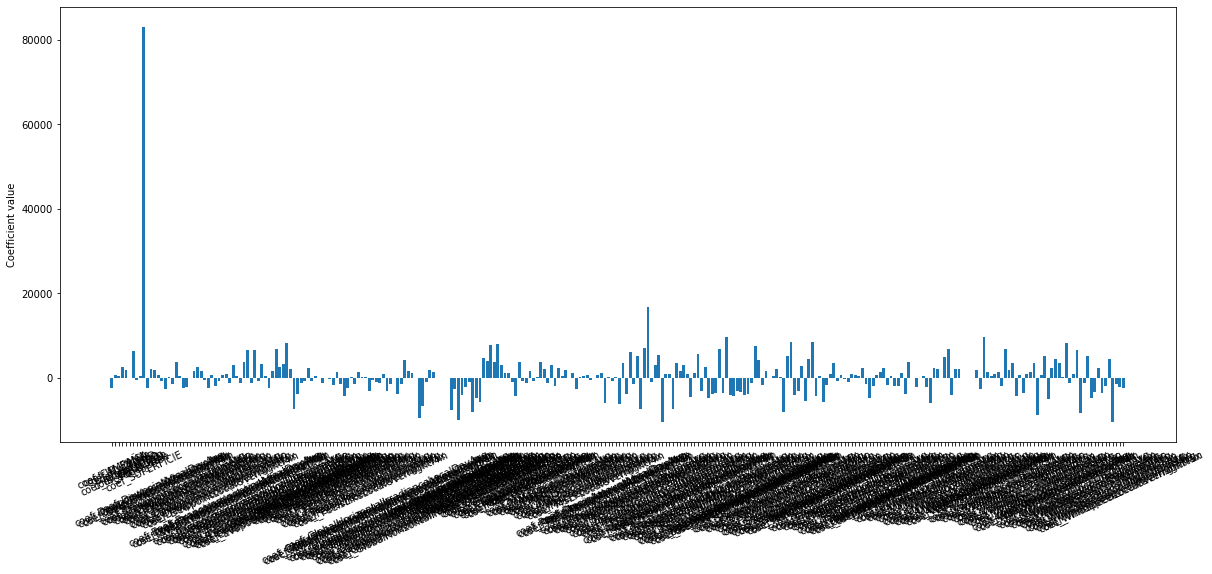

In [ ]:
coef_names = [f'coef_{X_columns[i]}' for i in range(X_norm.shape[1])]
plt.figure(figsize=(20,8))
plt.bar(coef_names, models['RidgeCV'].coef_)
plt.xticks(rotation=25)
plt.ylabel('Coefficient value')
plt.show()


Feature importance: {'CAMPAÑA': 0.0003, 'ID_FINCA': 0.21276, 'ID_ZONA': 0.08532, 'ID_ESTACION': 0.01387, 'ALTITUD': 0.07055, 'VARIEDAD': 0.13332, 'MODO': 0.06006, 'TIPO': 0.00118, 'COLOR': 0.00598, 'SUPERFICIE': 0.16157, 'date': 0.00017, 'DewpointLocalAfternoonAvg': 0.00113, 'DewpointLocalAfternoonMax': 0.00047, 'DewpointLocalAfternoonMin': 0.00187, 'DewpointLocalDayAvg': 0.00064, 'DewpointLocalDayMax': 0.00056, 'DewpointLocalDayMin': 0.0005, 'DewpointLocalDaytimeAvg': 0.00058, 'DewpointLocalDaytimeMax': 0.00062, 'DewpointLocalDaytimeMin': 0.00098, 'DewpointLocalEveningAvg': 0.00035, 'DewpointLocalEveningMax': 0.00042, 'DewpointLocalEveningMin': 0.00039, 'DewpointLocalMorningAvg': 0.00066, 'DewpointLocalMorningMax': 0.00058, 'DewpointLocalMorningMin': 0.00099, 'DewpointLocalNighttimeAvg': 0.00046, 'DewpointLocalNighttimeMax': 0.00047, 'DewpointLocalNighttimeMin': 0.00037, 'DewpointLocalOvernightAvg': 0.00043, 'DewpointLocalOvernightMax': 0.00093, 'DewpointLocalOvernightMin': 0.00079, '

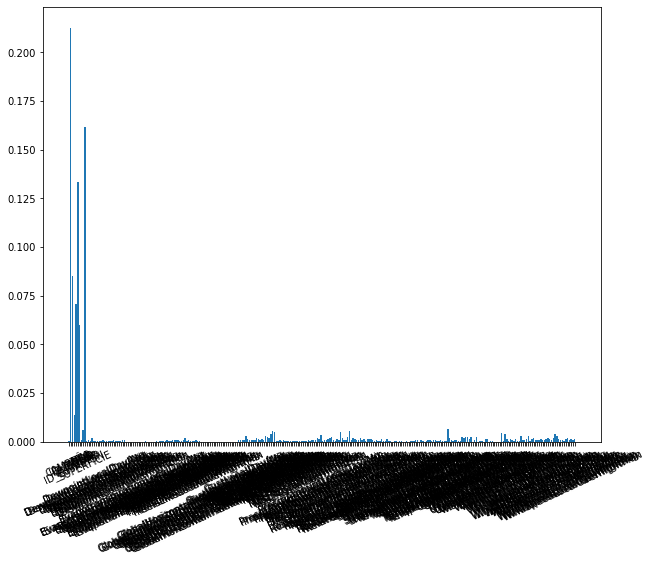

In [ ]:
# Extracting the importances by sklearn 
importances_rfr = models['RFR'].feature_importances_

# Creating a dataframe with the feature importance by sklearn
feature_importance_rfr = {}
for i, feature in enumerate(X_columns):
    feature_importance_rfr[feature] = round(importances_rfr[i], 5)

plt.figure(figsize=(10,8))
print(f"Feature importance: {feature_importance_rfr}")
plt.bar(feature_importance_rfr.keys(), feature_importance_rfr.values())
plt.xticks(rotation=25)
plt.show()

In [ ]:
sorted_feature_importance_rfr = sorted(feature_importance_dtr.items(), key=lambda x:x[1],reverse=True)
print(sorted_feature_importance_rfr)
print(np.sum( np.array(list(feature_importance_dtr.values())) >0.001))

[('ID_FINCA', 0.22828), ('SUPERFICIE', 0.1491), ('VARIEDAD', 0.14129), ('ID_ZONA', 0.0766), ('ALTITUD', 0.07283), ('MODO', 0.06085), ('ID_ESTACION', 0.0121), ('PrecipAmountLocalMorningMax', 0.00911), ('PrecipAmountLocalDayAvg', 0.00704), ('PrecipAmountLocalNighttimeMax', 0.007), ('VisibilityLocalOvernightMax', 0.0069), ('COLOR', 0.0062), ('PrecipAmountLocalNighttimeAvg', 0.00553), ('PrecipAmountLocalOvernightMax', 0.00464), ('PrecipAmountLocalEveningAvg', 0.00445), ('UVIndexLocalAfternoonAvg', 0.0044), ('GustLocalOvernightAvg', 0.00433), ('WindSpeedLocalDayMin', 0.00391), ('PrecipAmountLocalEveningMax', 0.00331), ('VisibilityLocalEveningMin', 0.00309), ('UVIndexLocalMorningAvg', 0.00301), ('PrecipAmountLocalMorningMin', 0.00264), ('TemperatureLocalMorningAvg', 0.00245), ('PrecipAmountLocalMorningAvg', 0.00237), ('PrecipAmountLocalOvernightAvg', 0.00237), ('GustLocalDayMax', 0.00236), ('RelativeHumidityLocalAfternoonMax', 0.00234), ('GustLocalEveningMin', 0.00225), ('GustLocalOvernightM

In [ ]:
t3.describe()

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,...,WindSpeedLocalEveningMin,WindSpeedLocalMorningAvg,WindSpeedLocalMorningMax,WindSpeedLocalMorningMin,WindSpeedLocalNighttimeAvg,WindSpeedLocalNighttimeMax,WindSpeedLocalNighttimeMin,WindSpeedLocalOvernightAvg,WindSpeedLocalOvernightMax,WindSpeedLocalOvernightMin
count,7338.000000,7338.000000,7338.00000,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000,...,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000
mean,17.955983,50751.208504,499.11202,12.191605,578.994004,45.515263,1.509131,0.013900,0.844917,0.597847,...,2.003770,2.656004,3.550781,1.879903,2.480556,3.827079,1.592944,2.193193,2.638228,1.757879
std,2.010494,29022.764870,260.99404,4.775919,76.102061,23.712210,0.499951,0.117085,0.362009,1.678556,...,0.195801,0.363904,0.445004,0.288137,0.240025,0.310398,0.189376,0.245899,0.281420,0.216229
min,15.000000,200.000000,7.00000,1.000000,370.000000,4.000000,1.000000,0.000000,0.000000,0.000000,...,1.344536,1.877838,2.536216,1.299454,1.896175,3.101366,1.017213,1.559016,1.945355,1.178689
25%,16.000000,25026.000000,284.00000,7.000000,490.000000,17.000000,1.000000,0.000000,1.000000,0.000000,...,1.833871,2.551913,3.485519,1.729863,2.254918,3.554098,1.424194,1.986301,2.432603,1.583880
50%,18.000000,50799.000000,464.00000,12.000000,610.000000,52.000000,2.000000,0.000000,1.000000,0.000000,...,2.002740,2.683836,3.626301,1.933699,2.487397,3.850959,1.594247,2.207397,2.678630,1.753973
75%,20.000000,76350.500000,726.00000,16.000000,635.000000,59.000000,2.000000,0.000000,1.000000,0.289860,...,2.170765,2.889315,3.859178,2.054577,2.673497,4.082240,1.750411,2.343989,2.818630,1.935246
max,21.000000,99693.000000,990.00000,19.000000,820.000000,94.000000,2.000000,1.000000,1.000000,26.850000,...,2.550411,3.390411,4.430137,2.541096,3.120548,4.635068,2.054247,2.804384,3.316986,2.307945


## REPERTICIO PER MESOS

NOV i DES de lany anterior

In [ ]:
for mes in range(1,13):
    m_str = ('0'+str(mes))[-2:] 
    
means = eto.groupby(['CAMPAÑA','ID_ESTACION']).mean()


# eto['CAMPAÑA'] = 
# eto['CAMPAÑA'] = eto['CAMPAÑA'].astype(int)

01
02
03
04
05
06
07
08
09
10
11
12


In [ ]:
means = eto.groupby(['CAMPAÑA','ID_ESTACION']).mean()

## REPERTICIO PER ÈPOQUES
<br>
<center><img src=https://raw.githubusercontent.com/AlbertRoca29/The-Wine-Project/main/img/ciclo_vegetativo_vid.jpg width=50%">
</center>
<br>



In [ ]:
# èpoques
# Reposo : 15 NOV any anterior - 10M aquest any
# MovReservas : 5M - 27M
# Crecimiento : 25M - 10A
# Maduracion  : 5A - 3O 

In [ ]:
# AFEGIR FECHAS VENDIMIA https://www.riberadelduero.es/consejo-regulador/estadisticas/fechas-de-vendimia

# PODEM FER UN PETIT DATASET O UN SIMPLE DICCIONARI
